# Project BUSA 523
[Dataset information](https://archive.ics.uci.edu/ml/datasets/Haberman%27s+Survival)

1. Perform Exploratory data analysis (20)
    * What can you conclude from methods of [central tendency](#Central-Tendency) &darr; and deviation of the variables?
        * <span style="color: #00386C">For **Age** and **Year** the means and medians are close to each other. **Auxillary nodes** have the opposite description.</span>
    * Are there any correlated variables?
        * <span style="color: #00386C">No columns are [correlated](#Correlation) &darr; to each other.</span>
    * Interpret the skewness of the variables.
        * <span style="color: #00386C">**Auxillary nodes** are quite skewed when viewing the [boxplot](#Boxplots) &darr;. Many values are zeros and the remainder spread a large range. A transformation of log() was applied where zeros are allowed to remain as zeros. The [Resource](https://opendatascience.com/transforming-skewed-data-for-machine-learning/) from our lessons says that lots of zeros are well suited for decision trees. I predict one of the tree alogoriths to do better than the others because of this. Outliers where not removed, because the data is still a little skewed and the outliers don't have a big gap from the end of the box plot.</span>

<div style="background: #00386c; padding: 1.5rem 3rem 2rem; color: #FFF;">

# Exploration and Preparation
    
</div>

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('cancer.csv')
data = data.rename(columns={'Survival ': 'Survival'})

Data appears to not have null data. Thanks!

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Age              305 non-null    int64
 1   Year             305 non-null    int64
 2   Auxillary nodes  305 non-null    int64
 3   Survival         305 non-null    int64
dtypes: int64(4)
memory usage: 9.7 KB


In [3]:
data.describe()

,Age,Year,Auxillary nodes,Survival
count,305.000000,305.000000,305.000000,305.000000
mean,52.531148,62.849180,4.036066,1.265574
std,10.744024,3.254078,7.199370,0.442364
min,30.000000,58.000000,0.000000,1.000000
25%,44.000000,60.000000,0.000000,1.000000
50%,52.000000,63.000000,1.000000,1.000000
75%,61.000000,66.000000,4.000000,2.000000
max,83.000000,69.000000,52.000000,2.000000


## Central Tendency

In [4]:
# Including this table to be sure mode is in there.
central_tendencies = dict()
for col in data.columns:
    central_tendencies[col] = {
        'mean': data[col].mean(),
        'median': data[col].median(),
        'mode' : ', '.join(list(map(str, data[col].mode())))
    }

pd.DataFrame(central_tendencies).T

,mean,median,mode
Age,52.531148,52.0,52
Year,62.84918,63.0,58
Auxillary nodes,4.036066,1.0,0
Survival,1.265574,1.0,1


## Boxplots

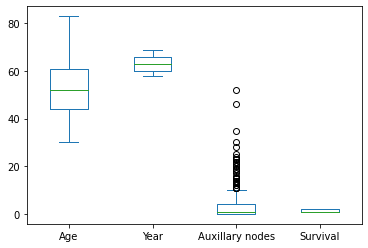

In [5]:
_ = data.plot.box()

In [6]:
data.skew()

Age                0.158986
Year               0.082021
Auxillary nodes    2.977682
Survival           1.066875
dtype: float64

I've decided to improve the skewness of **Auxillary nodes** rather than remove the outliers. The outliers of course appear to be the interesting numbers when the majority of records are zeros.

In [7]:
s = pd.Series((data['Auxillary nodes'].apply(lambda x: 0 if x == 0 else np.log(x))))
s.skew()

1.0510341623699009

<AxesSubplot:>

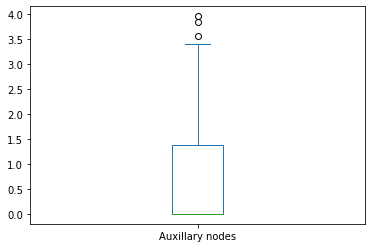

In [8]:
# now there's only 3 outliers which I will leave in due to the skewness of the data.
s.plot.box()

In [9]:
prepared_data = data.drop(columns=['Auxillary nodes'])
prepared_data['Auxillary nodes'] = s
prepared_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              305 non-null    int64  
 1   Year             305 non-null    int64  
 2   Survival         305 non-null    int64  
 3   Auxillary nodes  305 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 9.7 KB


## Correlation

In [10]:
# Running corr after skew transformation since it was a non-linear transform.
prepared_data.corr()

,Age,Year,Survival,Auxillary nodes
Age,1.000000,0.092623,0.064351,-0.089596
Year,0.092623,1.000000,-0.004076,0.003803
Survival,0.064351,-0.004076,1.000000,0.336432
Auxillary nodes,-0.089596,0.003803,0.336432,1.000000


<div style="background: #00386c; padding: 1.5rem 3rem 2rem; color: #FFF">

# Machine Learning
    
</div>


2. Develop Supervised learning models. (50)
    * [Logistic Regression](#Logistic-Regression)&darr;
    * [Random Forest](#Random-Forest)&darr;
    * [Support Vector Machine](#Support-Vector-Machine)&darr;
    * [Neural Network](#Neural-Network)&darr;
   
   [Compare](#Fit-measuring)&darr; the 4 methods based on the performance metrics and identify the best model for this problem.
   * Use 10-fold cross validation.
   * Use GridSearchCV for searching through hyper parameters.
3. Evaluate if the algorithms are overfitting? (10)
    * <span style="color: #00386c">Fits are evaulated on each model and available in a table in the [camparison section](#Comparison)&darr;. All came out to a good fit, but some work was done on the random forest to get it to not overfit. A parameter of cv=10 was added to the gridSearches to add 10 fold validation when searching for hyperparameters. This helped.</span>
4. Develop a function which can implement [machine learning](#Machine-Learning-Function)&darr;. (20)
```python
def machine_learning(data,algorithm):
    #code goes here
    #plot ROC curve
    return performance_metrics
```
Function call: machine_learning(data, neural_network)

In [11]:
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve # Area Under Curve 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC # Support Vector Machine
from sklearn.neural_network import MLPClassifier # Neural Network
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Fit measuring
with 10 fold cross-validation

In [12]:
def is_good_fit(data, clf, n_splits=10, epsilon=0.10, label_column='Survival', random_state=10):
    X = prepared_data.drop(columns=[label_column])
    y = prepared_data[label_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state, train_size = 0.6)
    
    kf = KFold(n_splits=n_splits)
    scores = []
    for iteration, (train_indices, test_indices) in enumerate(kf.split(X_train), 1):
        X_train_slice, y_train_slice = X_train.iloc[train_indices], y_train.iloc[train_indices]
        X_test_slice, y_test_slice = X_train.iloc[test_indices], y_train.iloc[test_indices]
        clf.fit(X_train_slice, y_train_slice)
        scores.append(clf.score(X_test_slice, y_test_slice))
    clf.fit(X_train, y_train)
    full_score = clf.score(X_test, y_test)
    
    #MATH
    avg_fold_score = np.mean(scores)
    good_fit = abs(avg_fold_score - full_score) < epsilon
    if good_fit:
        print('This model is well fit')
    else:
        print('This model is not well fit')

## Machine Learning Function

In [13]:
def machine_learning(data, algorithm, label_column='Survival', random_state=10):
    X = prepared_data.drop(columns=[label_column])
    y = prepared_data[label_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state, train_size = 0.6)
    
    algorithm.fit(X_train, y_train)
    y_pred = algorithm.predict(X_test)
    plot_roc_curve(algorithm, X_test, y_test)
    cr = classification_report(y_test, y_pred, labels = algorithm.classes_)
    cm = confusion_matrix(y_test, y_pred, labels = algorithm.classes_)
    return cr, cm

## Constants

In [14]:
labels = ["Survived", "Died"]
random_state = 10
minMaxScaler = MinMaxScaler()
standardScaler = StandardScaler()
robustScaler = RobustScaler()
# prepared_data already in environment
#X = scaleDF(prepared_data.drop(columns=['Survival']), MinMaxScaler)
X = prepared_data.drop(columns=['Survival'])
y = prepared_data['Survival']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state, train_size = 0.6)

## Logistic Regression

The GridSearch process doesn't cooperate well with the kFold best fit. The combination makes a lot of time be spent. I ran GridSearch for each algorithm and got the best values. Then, I turned it off.

              precision    recall  f1-score   support

           1       0.84      0.87      0.85        97
           2       0.41      0.36      0.38        25

    accuracy                           0.76       122
   macro avg       0.62      0.61      0.62       122
weighted avg       0.75      0.76      0.76       122

This model is well fit


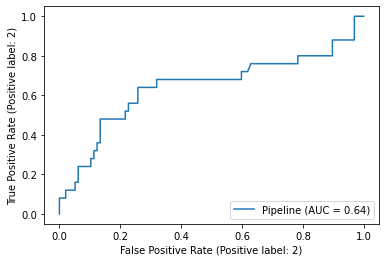

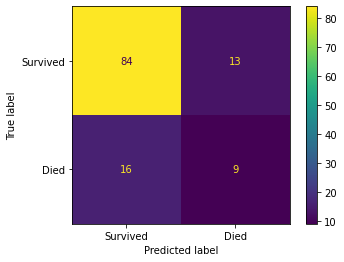

In [15]:
# Logistic Regression

# Defining and training the model
# clf_parameters = {
#     'logistic__solver': ['liblinear', 'saga'], #not dealing with multiclass problem so liblinear should be fine.
#     'logistic__penalty':['l2', 'l1'],
#     'logistic__C': [100, 10, 1.0, .1, .01],
#     'logistic__max_iter': [1000],
# }

clf_final_parameters = {
    'C': 1.0,
    'max_iter': 1000,
    'penalty': 'l2',
    'solver': 'saga'
}

clf_pipe = Pipeline(steps=[
    ('scaler', standardScaler),
    ('logistic', LogisticRegression(random_state = random_state, **clf_final_parameters))
])
# clf_search = GridSearchCV(clf_pipe, clf_parameters, cv=10)
cr, cm = machine_learning(prepared_data, clf_pipe)
# print(clf_search.best_params_)
print(cr)
is_good_fit(prepared_data, clf_pipe)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels).plot()


## Random Forest

              precision    recall  f1-score   support

           1       0.83      0.91      0.87        97
           2       0.44      0.28      0.34        25

    accuracy                           0.78       122
   macro avg       0.63      0.59      0.60       122
weighted avg       0.75      0.78      0.76       122

This model is well fit


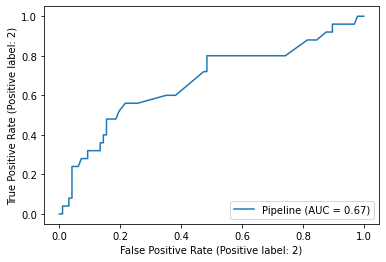

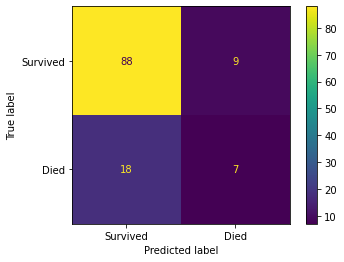

In [16]:
# Developing and fitting the random forest algorithm
# rf_parameters = {
#     'rf__max_features': [1, 2, 3],
#     'rf__n_estimators':[10, 100, 1000],
#     'rf__max_depth': [None, 3, 5, 10, 50],
#     'rf__min_samples_leaf': [1, 2, 3, 4]
# }
rf_final_params = {
    'max_depth': 3, 
    'max_features': 2, 
    'min_samples_leaf': 2, 
    'n_estimators': 10
}
rf_pipe = Pipeline(steps=[
    ('scaler', standardScaler),
    ('rf', RandomForestClassifier(random_state = random_state, **rf_final_params))
])
# rf_search = GridSearchCV(rf_pipe, rf_parameters, cv=10, n_jobs=4)
cr, cm = machine_learning(prepared_data, rf_pipe)
# print(rf_search.best_params_)
print(cr)
is_good_fit(prepared_data, rf_pipe)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels).plot()


## Neural Network

              precision    recall  f1-score   support

           1       0.85      0.87      0.86        97
           2       0.43      0.40      0.42        25

    accuracy                           0.77       122
   macro avg       0.64      0.63      0.64       122
weighted avg       0.76      0.77      0.77       122

This model is well fit


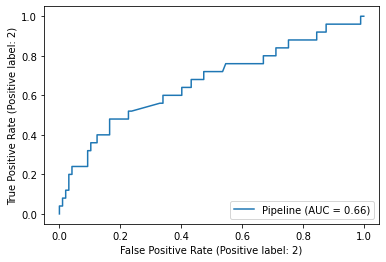

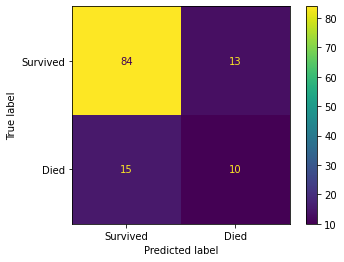

In [17]:
# Developing and fitting the Neural Network
# parameters = {
#     'nn__hidden_layer_sizes':[
#         None,
#         (2,), (3,), (4,),
#         (2,2), (2,3), (2, 4),
#         (3,2), (3,3), (3,4),
#         (4,2), (4,3), (4,4),  
#     ],
#     'nn__solver':['lbfgs', 'adam'],
#     #'learning_rate': ['constant', 'invscaling', 'adaptive'],
#     'nn__learning_rate_init': [.01],
#     'nn__activation': ['relu'],
#     'nn__max_iter': [1000],
#     'nn__alpha': [.0001]
# }



nn_final_params = {
    'activation': 'relu',
    'alpha': 0.0001,
    'hidden_layer_sizes': (4,),
    'learning_rate_init': 0.01,
    'max_iter': 1000,
    'solver': 'adam'
}

nn_pipe = Pipeline(steps=[
    ('scaler', standardScaler),
    ('nn', MLPClassifier(random_state=random_state, **nn_final_params))
])

# nn_search = GridSearchCV(nn_pipe, parameters, cv=10)
cr, cm = machine_learning(prepared_data, nn_pipe)
# print(nn_search.best_params_)
print(cr)
is_good_fit(prepared_data, nn_pipe)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels).plot()


## Support Vector Machine

              precision    recall  f1-score   support

           1       0.85      0.85      0.85        97
           2       0.42      0.44      0.43        25

    accuracy                           0.76       122
   macro avg       0.64      0.64      0.64       122
weighted avg       0.77      0.76      0.76       122

This model is well fit


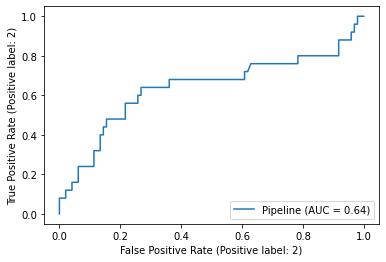

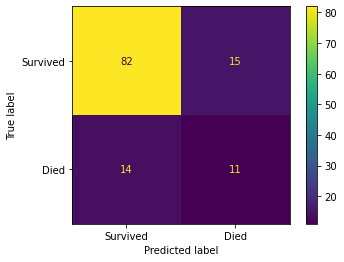

In [18]:
# Developing and fitting the Support Vector Machine
# parameters = {
#     'svm__kernel':['linear', 'rbf'],
#     'svm__C':[100, 10, 1, 0.1, 0.01, 0.001],
#     #'svm__degree': [2, 3],
# }
svm_final_params = {'C': 100, 'kernel': 'linear'}
svm_pipe = Pipeline(steps=[
    ('scaler', robustScaler),
    ('svm', SVC(random_state = random_state, **svm_final_params))
])
# svm_search = GridSearchCV(svm_pipe, parameters, cv=10, n_jobs=8)
cr, cm = machine_learning(data, svm_pipe)
# print(svm_search.best_params_)
print(cr)
is_good_fit(prepared_data, svm_pipe)
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels).plot()

## Comparison

We're trying to increase the precision of Survival predictions(1) and the recall of non-Survival predictions. We're less worried about be people that will survive and are predicted to die when survival of the most people is the goal.

| |Precision of 1 |Recall of 2 |Fit|
|:---|:---:|:---:|---|
|Logistic  |0.84  |0.36  |✔|
|Random Forest  |0.83 |0.28  |✔|
|Neural Network  |0.85  |0.40  |✔ |
|SVM  |0.85  |0.44  |✔ |

Looks like the SVM Model wins out.